# Week 3 - Attitude Control of States and Rates

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r"../")
import AttitudeKinematicsLib as ak

In [2]:
print("Contents of AttitudeKinematicsLib:")
for name in sorted(dir(ak)):
    if not name.startswith("_"):
        print(name)

Contents of AttitudeKinematicsLib:
BInvmat_CRP
BInvmat_EP
BInvmat_Euler
BInvmat_MRP
BInvmat_PRV
Bmat_CRP
Bmat_EP
Bmat_Euler
Bmat_MRP
Bmat_PRV
CRP
CRP_to_DCM
DCM_to_CRP
DCM_to_EP
DCM_to_Euler
DCM_to_MRP
DCM_to_PRV
DCM_utils
EP_to_DCM
EulerAngles
EulerRodriguesParameters
Euler_to_DCM
MRP
MRP_to_DCM
PRV
PRV_to_DCM
integrate_quaternion
normalize_quat
np
quat_derivative
quat_diff
quat_inv
quat_mult
rotation_matrix_x
rotation_matrix_y
rotation_matrix_z
skew_symmetric
solve_ivp
validate_DCM
validate_vec3
validate_vec4


In [3]:
def rk4_step(f, t, x, dt, *args, **kwargs):
    """
    Advance one timestep using classical 4th-order Runge–Kutta (RK4).
    
    Parameters
    ----------
    f : callable
        RHS function with signature f(t, x, *args, **kwargs) -> xdot.
    t : float
        Current time.
    x : np.ndarray
        Current state vector.
    dt : float
        Timestep size.
    *args, **kwargs
        Extra arguments passed through to `f`.
    
    Returns
    -------
    x_next : np.ndarray
        State advanced by one RK4 step of size `dt`.
    """
    k1 = f(t, x, *args, **kwargs)
    k2 = f(t + 0.5*dt, x + 0.5*dt*k1, *args, **kwargs)
    k3 = f(t + 0.5*dt, x + 0.5*dt*k2, *args, **kwargs)
    k4 = f(t + dt, x + dt*k3, *args, **kwargs)
    x_next = x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)
    return x_next


In [4]:
def mrp_shadow(sigma: np.ndarray) -> np.ndarray:
    """
    Apply MRP shadow set if ||sigma|| > 1.
    Keeps MRPs numerically well-conditioned.
    """
    s2 = float(sigma @ sigma)
    if s2 > 1.0:
        return -sigma / s2
    return sigma

In [5]:
def mrp_compose(s1, s2, mode="add"):
    """
    mrp_compose(s1, s2, mode)

    Q = mrp_compose(s1, s2, mode) provides the MRP vector corresponding to:

        mode = "add" :
            successive rotations s1 followed by s2

        mode = "sub" :
            relative rotation from s2 to s1

    This is a unified implementation of addMRP and subMRP.
    """

    # Ensure column-like vectors (but works with 1D arrays)
    s1 = np.asarray(s1, dtype=float).reshape(3,)
    s2 = np.asarray(s2, dtype=float).reshape(3,)

    s1_sq = np.dot(s1, s1)
    s2_sq = np.dot(s2, s2)
    s1_dot_s2 = np.dot(s1, s2)
    s1_cross_s2 = np.cross(s1, s2)

    if mode == "add":
        # --- MRP addition (successive rotations) ---
        q = ((1 - s1_sq) * s2 + (1 - s2_sq) * s1 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq - 2 * s1_dot_s2)

    elif mode == "sub":
        # --- MRP subtraction (relative attitude) ---
        q = ((1 - s2_sq) * s1 - (1 - s1_sq) * s2 + 2 * s1_cross_s2)
        q = q / (1 + s1_sq * s2_sq + 2 * s1_dot_s2)

    else:
        raise ValueError("mode must be 'add' or 'sub'")

    return mrp_shadow(q)


## CC1, Q4

In [6]:
def cc1_q4_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    Q4 nonlinear attitude regulator (PD + gyro compensation).

    State:
        state["sigma_BN"]: MRPs of body B relative to inertial N
        state["omega_BN_B"]: angular rate of B wrt N, expressed in B [rad/s]

    Reference (regulator usage):
        ref["sigma_RN"] = zeros(3)
        ref["omega_RN_R"] = zeros(3)
        ref["omega_dot_RN_R"] = zeros(3)

    Context:
        ctx["I"]: inertia matrix in body frame B
        ctx["K"]: attitude gain
        ctx["P"]: rate gain
        ctx["L_B"]: external disturbance torque in B (default zero)

    Output:
        u_B: control torque expressed in body frame B
    """
    # --- unpack state ---
    sigma_BN = state["sigma_BN"]
    omega_BN_B = state["omega_BN_B"]

    # --- unpack reference (defaults to zero for regulator) ---
    sigma_RN = ref.get("sigma_RN", np.zeros(3))
    omega_RN_R = ref.get("omega_RN_R", np.zeros(3))

    # --- unpack context ---
    I = ctx["I"]
    K = ctx["K"]
    P = ctx["P"]
    L_B = ctx.get("L_B", np.zeros(3))

    # -------------------------
    # 1) Attitude error
    # -------------------------
    # sigma_BR = sigma_BN (-) sigma_RN
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # -------------------------
    # 2) Rate error
    # -------------------------
    # Regulator usage: omega_RN_R = 0
    omega_BR_B = omega_BN_B - omega_RN_R

    # -------------------------
    # 3) Control law (Q4)
    # -------------------------
    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - L_B
    )

    return u_B



In [7]:
def cc_plant(
    t: float,
    state: dict,
    u_B: np.ndarray,
    ref: dict,
    ctx: dict,
) -> dict:
    """
    Attitude plant model (MRP kinematics + rigid-body rotational dynamics).

    Inputs:
        state["sigma_BN"]: MRPs of body B relative to inertial N
        state["omega_BN_B"]: angular rate of B wrt N, expressed in B [rad/s]
        u_B: applied control torque in B [N*m]
        ctx["I"]: inertia matrix in B
        ctx["L_B"]: external disturbance torque in B (optional; default zeros)

    Output:
        state_dot: dict with keys "sigma_BN" and "omega_BN_B"
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    L_B = np.asarray(ctx.get("L_B", np.zeros(3)), dtype=float).reshape(3,)
    u_B = np.asarray(u_B, dtype=float).reshape(3,)

    omega_dot_B = np.linalg.solve(I, u_B + L_B - np.cross(omega_BN_B, I @ omega_BN_B))
    sigma_dot = 0.25 * (ak.Bmat_MRP(sigma_BN) @ omega_BN_B)

    state_dot = {
        "sigma_BN": sigma_dot,
        "omega_BN_B": omega_dot_B,
    }
    return state_dot


In [8]:
def cc_xdot(
    t: float,
    x: np.ndarray,
    controller,
    plant_dynamics,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    Closed-loop state derivative (wrapper around controller + plant).

    Inputs:
        x: state vector [sigma_BN (3), omega_BN_B (3)]
        controller: u_B = controller(t, state, ref, ctx)
        plant_dynamics: state_dot = plant_dynamics(t, state, u_B, ref, ctx)
        ref: reference dict with keys {"sigma_RN","omega_RN_R","omega_dot_RN_R"}
        ctx: context dict with at least {"I","K","P","L_B"}

    Output:
        xdot: state derivative vector [sigma_dot (3), omega_dot_B (3)]
    """
    x = np.asarray(x, dtype=float).reshape(-1,)
    if x.size != 6:
        raise ValueError(f"cc_xdot expects state length 6, got {x.size}")

    sigma_BN = x[0:3]
    omega_BN_B = x[3:6]

    state = {
        "sigma_BN": sigma_BN,
        "omega_BN_B": omega_BN_B,
    }

    u_B = controller(t, state, ref, ctx)
    state_dot = plant_dynamics(t, state, u_B, ref, ctx)

    xdot = np.hstack((state_dot["sigma_BN"], state_dot["omega_BN_B"]))
    return xdot


In [ ]:
def simulate_CC(
    controller=cc1_q4_controller_u,
    plant_dynamics=cc_plant,
    state_derivative=cc_xdot,
    context: dict | None = None,
    t0: float = 0.0,
    tf: float = 120.0,
    dt: float = 0.01,
    sigma0: np.ndarray | None = None,
    omega0_deg: np.ndarray | None = None,
    eta0: np.ndarray | None = None,
    ref_mode: str = "tracking",
    f: float = 0.05,
    report_time_s: float = 40.0,
    report_quantity: str = "sigma_BR",
):
    """
    RK4 simulator harness for attitude concept checks.

    Inputs:
        controller: u_B = controller(t, state, ref, ctx)
        plant_dynamics: state_dot = plant_dynamics(t, state, u_B, ref, ctx)
        state_derivative: xdot = state_derivative(t, x, controller, plant_dynamics, ref, ctx)
        context: dictionary of model/controller parameters (e.g., I, K, P, deltaL_B, modelL_B, Ki, omega_BR0_B)

    Output:
        results: dict with time histories for state, control, Lyapunov metric, and error signals.
    """
    # -------------------------
    # Context: create defaults
    # -------------------------
    if context is None:
        context = {}

    # Inertia
    if "I" not in context or context["I"] is None:
        context["I"] = np.diag([100.0, 75.0, 80.0])
    context["I"] = np.asarray(context["I"], dtype=float)
    if context["I"].shape != (3, 3):
        raise ValueError(f"context['I'] must be shape (3,3), got {context['I'].shape}")

    # Gains (defaults preserve your old behavior)
    context.setdefault("K", 5.0)
    context.setdefault("P", 10.0)

    # Disturbance conventions
    # deltaL_B / L_B : external torque applied to the plant dynamics
    #                  (i.e. the spacecraft actually experiences this torque)
    # modelL_B       : external torque assumed/known by the controller and
    #                  explicitly compensated in the control law (via a "-L" term)
    #
    # Precedence rule:
    #   - deltaL_B is the canonical plant disturbance
    #   - L_B is a legacy alias for deltaL_B (for backward compatibility)
    #   - modelL_B is independent and only affects the controller
    #   - If both deltaL_B and L_B are provided, deltaL_B takes precedence
    if "deltaL_B" not in context and "L_B" in context:
        context["deltaL_B"] = context["L_B"]

    # If user provided deltaL_B but not legacy L_B, create the legacy alias
    if "L_B" not in context and "deltaL_B" in context:
        context["L_B"] = context["deltaL_B"]

    # Ensure both exist (safe defaults)
    context.setdefault("deltaL_B", np.zeros(3))
    context.setdefault("modelL_B", np.zeros(3))
    context.setdefault("L_B", context["deltaL_B"])

    context["deltaL_B"] = np.asarray(context["deltaL_B"], dtype=float).reshape(3,)
    context["modelL_B"] = np.asarray(context["modelL_B"], dtype=float).reshape(3,)
    context["L_B"] = np.asarray(context["L_B"], dtype=float).reshape(3,)

    # -------------------------
    # Initial conditions
    # -------------------------
    sigma0 = np.asarray(sigma0 if sigma0 is not None else [0.1, 0.2, -0.1], dtype=float).reshape(3,)
    omega0_deg = np.asarray(omega0_deg if omega0_deg is not None else [30.0, 10.0, -20.0], dtype=float).reshape(3,)
    omega0 = np.deg2rad(omega0_deg)

    # State: x = [sigma_BN, omega_BN_B] or [sigma_BN, omega_BN_B, eta]
    if eta0 is None:
        x = np.hstack((sigma0, omega0))
    else:
        eta0 = np.asarray(eta0, dtype=float).reshape(3,)
        x = np.hstack((sigma0, omega0, eta0))

    x[0:3] = mrp_shadow(x[0:3])

    # -------------------------
    # Time base
    # -------------------------
    t_hist = np.arange(t0, tf + dt, dt)
    N = t_hist.size

    # -------------------------
    # Reference signals
    # -------------------------
    sigma_RN_hist = np.zeros((N, 3))
    omega_RN_R_hist = np.zeros((N, 3))
    omega_dot_RN_R_hist = np.zeros((N, 3))

    if ref_mode.lower() == "tracking":
        for k, t in enumerate(t_hist):
            st = np.sin(f * t)
            ct = np.cos(f * t)
            sigma_RN = np.array([0.2 * st, 0.3 * ct, -0.3 * st], dtype=float)
            sigma_RN_dot = np.array([0.2 * f * ct, -0.3 * f * st, -0.3 * f * ct], dtype=float)

            sigma_RN_hist[k] = sigma_RN
            omega_RN_R_hist[k] = 4.0 * ak.BInvmat_MRP(sigma_RN) @ sigma_RN_dot

        omega_dot_RN_R_hist[:] = np.gradient(omega_RN_R_hist, t_hist, axis=0)

    elif ref_mode == "regulator":
        pass
    else:
        raise ValueError("ref_mode must be 'tracking' or 'regulator'")

    # -------------------------
    # Storage (dimension-agnostic)
    # -------------------------
    x_hist = np.zeros((N, x.size))
    u_hist = np.zeros((N, 3))
    V_hist = np.zeros(N)
    sigma_BR_hist = np.zeros((N, 3))
    omega_BR_hist = np.zeros((N, 3))
    sigma_norm_hist = np.zeros(N)

    # -------------------------
    # Simulation loop
    # -------------------------
    I = context["I"]
    K = context["K"]

    for k, t in enumerate(t_hist):
        sigma_BN = x[0:3]
        omega_BN_B = x[3:6]

        state = {
            "sigma_BN": sigma_BN,
            "omega_BN_B": omega_BN_B,
        }
        if x.size == 9:
            state["eta"] = x[6:9]

        ref = {
            "sigma_RN": sigma_RN_hist[k],
            "omega_RN_R": omega_RN_R_hist[k],
            "omega_dot_RN_R": omega_dot_RN_R_hist[k],
        }

        # Errors (logging)
        sigma_BR = mrp_compose(sigma_BN, ref["sigma_RN"], mode="sub")
        C_BR = ak.MRP_to_DCM(sigma_BN) @ ak.MRP_to_DCM(ref["sigma_RN"]).T
        omega_BR_B = omega_BN_B - C_BR @ ref["omega_RN_R"]

        sigma_BR_hist[k] = sigma_BR
        omega_BR_hist[k] = omega_BR_B
        sigma_norm_hist[k] = (
            np.linalg.norm(sigma_BN)
            if report_quantity == "sigma_BN"
            else np.linalg.norm(sigma_BR)
        )

        # Control
        u_B = controller(t, state, ref, context)
        u_hist[k] = u_B

        V_hist[k] = 0.5 * omega_BR_B @ (I @ omega_BR_B) + 2.0 * K * np.log(1.0 + sigma_BR @ sigma_BR)

        x_hist[k] = x

        # Integrate (skip on last step)
        if k < N - 1:
            x = rk4_step(
                state_derivative,
                t,
                x,
                dt,
                controller,
                plant_dynamics,
                ref,
                context,
            )
            x[0:3] = mrp_shadow(x[0:3])

    # -------------------------
    # Report
    # -------------------------
    idx = np.argmin(np.abs(t_hist - report_time_s))
    label = "sigma_B/N" if report_quantity == "sigma_BN" else "sigma_B/R"
    print(f"CC: ||{label}|| at t={t_hist[idx]:.3f} s = {sigma_norm_hist[idx]:.15f}")

    results = {
        "t": t_hist,
        "x": x_hist,
        "u": u_hist,
        "V": V_hist,
        "sigma_norm": sigma_norm_hist,
        "sigma_BR": sigma_BR_hist,
        "omega_BR": omega_BR_hist,
        "params": context,
    }
    return results



In [10]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.0, 0.0, 0.0], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "L_B": L
}

cc1q4_sim_result = simulate_CC(
    controller=cc1_q4_controller_u,
    plant_dynamics=cc_plant,
    state_derivative=cc_xdot,
    context=context,
    t0=0.0,
    tf=120.0,
    dt=0.01,
    sigma0=sigma0,
    omega0_deg=omega0_deg,
    ref_mode='regulator',
    f=0.0, 
    report_time_s=30.0,
    report_quantity="sigma_BN", 
    )
cc1q4_sim_result

CC: ||sigma_B/N|| at t=30.000 s = 0.194751484380332


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01029530e-01,  2.00444264e-01, -1.01317420e-01,
          5.23025206e-01,  1.74166977e-01, -3.48566918e-01],
        [ 1.02058633e-01,  2.00886941e-01, -1.02634236e-01,
          5.22451696e-01,  1.73801221e-01, -3.48067787e-01],
        ...,
        [-1.01918765e-03,  3.57166023e-05,  5.41518866e-04,
         -3.76251395e-04,  4.65355768e-05, -8.66779721e-05],
        [-1.02012731e-03,  3.58313740e-05,  5.41301715e-04,
         -3.75365758e-04,  4.64497372e-05, -8.69078624e-05],
        [-1.02106476e-03,  3.59459324e-05,  5.41083990e-04,
         -3.74480537e-04,  4.63639357e-05, -8.71373296e-05]]),
 'u': array([[-6.04060518e+00, -6.40073829e+00,  1.70602786e+00],
        [-6.03894394e+00, -6.39007678e+00,  1.71491330e+00],
        [-6.03728315e+00, -

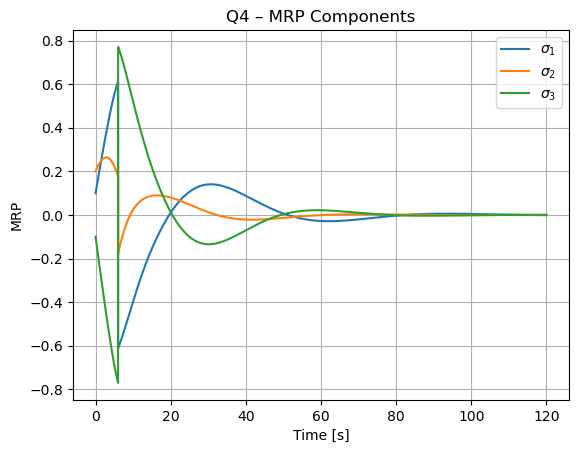

In [11]:
t = cc1q4_sim_result['t']
x = cc1q4_sim_result['x']
u = cc1q4_sim_result['u']
V = cc1q4_sim_result['V']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q4 – MRP Components")
plt.legend()
plt.show()

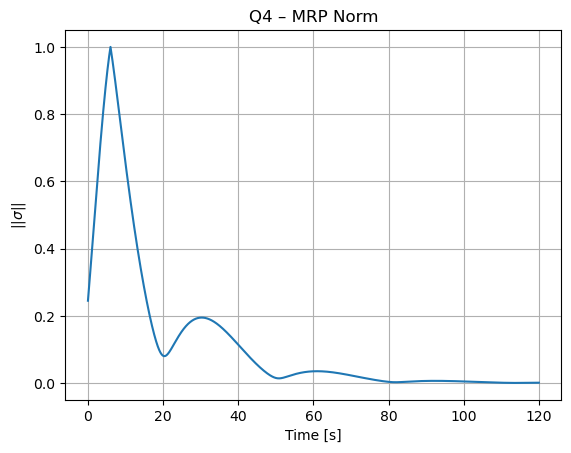

In [12]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma||$")
plt.title("Q4 – MRP Norm")
plt.show()


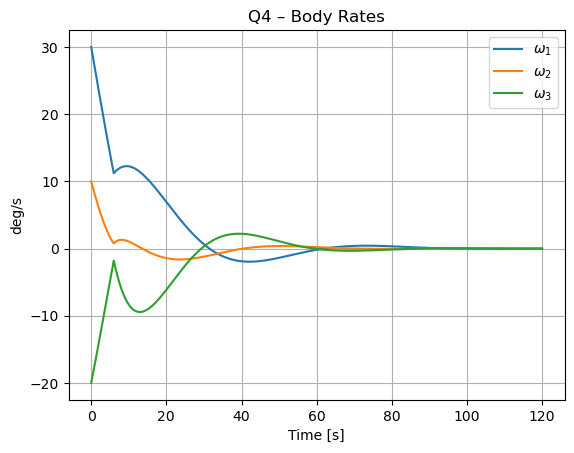

In [13]:
plt.figure()
plt.plot(t, omega_deg[:, 0], label=r'$\omega_1$')
plt.plot(t, omega_deg[:, 1], label=r'$\omega_2$')
plt.plot(t, omega_deg[:, 2], label=r'$\omega_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q4 – Body Rates")
plt.legend()
plt.show()

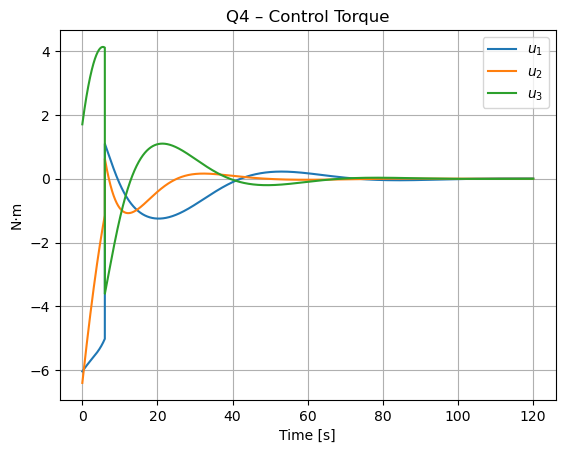

In [14]:
plt.figure()
plt.plot(t, u[:, 0], label=r'$u_1$')
plt.plot(t, u[:, 1], label=r'$u_2$')
plt.plot(t, u[:, 2], label=r'$u_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("N·m")
plt.title("Q4 – Control Torque")
plt.legend()
plt.show()


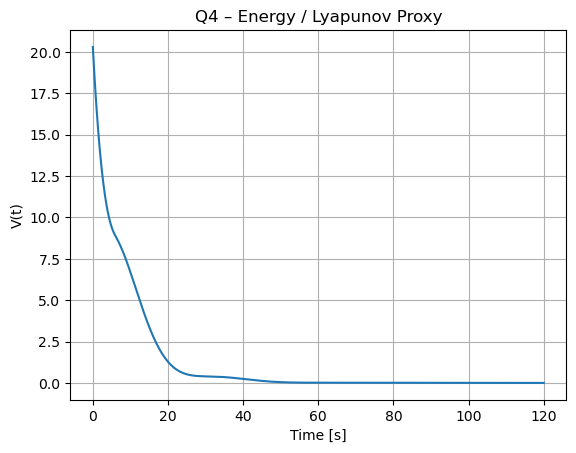

In [15]:
plt.figure()
plt.plot(t, V)
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("V(t)")
plt.title("Q4 – Energy / Lyapunov Proxy")
plt.show()


## CC1, Q5

In [16]:
def cc1_q5_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC1/Q5 attitude tracking controller.

    Inputs:
        state["sigma_BN"], state["omega_BN_B"]
        ref["sigma_RN"], ref["omega_RN_R"], ref["omega_dot_RN_R"]
        ctx["I"], ctx["K"], ctx["P"], ctx["L_B"] (optional; default zeros)

    Output:
        u_B: (3,) control torque in body frame B
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref["sigma_RN"], dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref["omega_RN_R"], dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref["omega_dot_RN_R"], dtype=float).reshape(3,)

    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    K = float(ctx["K"])
    P = float(ctx["P"])
    L_B = np.asarray(ctx.get("L_B", np.zeros(3)), dtype=float).reshape(3,)

    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - L_B
    )
    return u_B


In [17]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.0, 0.0, 0.0], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "L_B": L
}

cc1q5_sim_result = simulate_CC(
    controller=cc1_q5_controller_u, 
    plant_dynamics=cc_plant,
    state_derivative=cc_xdot,
    context=context,
    sigma0=sigma0,
    omega0_deg=omega0_deg,
    t0=0.0,
    tf=120.0,
    dt=0.01,
    ref_mode='tracking', 
    f=0.05,
    report_time_s=40.0,
    report_quantity="sigma_BR",
    )

cc1q5_sim_result

CC: ||sigma_B/R|| at t=40.000 s = 0.158824440175250


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102978,  0.20044435, -0.1013174 ,  0.52317894,  0.17427501,
         -0.34850358],
        [ 0.10205962,  0.20088729, -0.10263417,  0.52275878,  0.1740182 ,
         -0.34794107],
        ...,
        [-0.05652822,  0.28803467,  0.08422553,  0.06062813,  0.01184204,
         -0.02395373],
        [-0.05642969,  0.28807731,  0.0840797 ,  0.06063226,  0.01182167,
         -0.02396006],
        [-0.05633115,  0.28811987,  0.08393385,  0.06063638,  0.01180131,
         -0.02396637]]),
 'u': array([[-4.50077163, -5.5938201 ,  2.21276505],
        [-4.5031082 , -5.5766913 ,  2.21993471],
        [-4.50551686, -5.55954676,  2.22707241],
        ...,
        [ 0.04026097, -0.18178618, -0.06871974],
        [ 0.04017335, -0.18182018, -0.06860042],
        [ 0.04012846, -0.18184159, 

In [18]:
t = cc1q5_sim_result["t"]
x = cc1q5_sim_result["x"]
sigma_BR = cc1q5_sim_result["sigma_BR"]
omega_BR = cc1q5_sim_result["omega_BR"]

sigma_BN = x[:, 0:3]
omega_BN = x[:, 3:6]
omega_BN_deg = np.rad2deg(omega_BN)

omega_BR_deg = np.rad2deg(omega_BR)

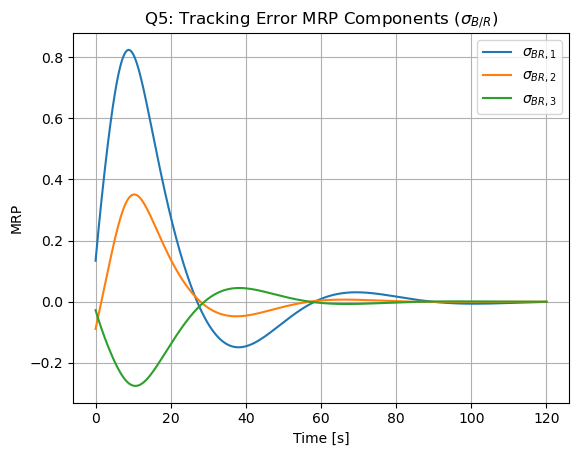

In [19]:
plt.figure()
plt.plot(t, sigma_BR[:, 0], label=r'$\sigma_{BR,1}$')
plt.plot(t, sigma_BR[:, 1], label=r'$\sigma_{BR,2}$')
plt.plot(t, sigma_BR[:, 2], label=r'$\sigma_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Tracking Error MRP Components ($\\sigma_{B/R}$)")
plt.legend()
plt.show()


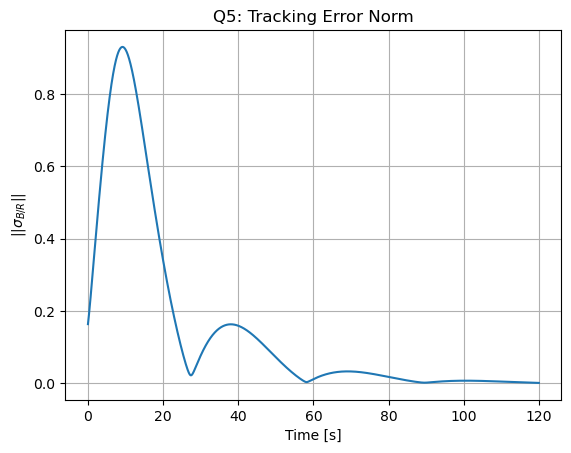

In [20]:
plt.figure()
plt.plot(t, np.linalg.norm(sigma_BR, axis=1))
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel(r"$||\sigma_{B/R}||$")
plt.title("Q5: Tracking Error Norm")
plt.show()


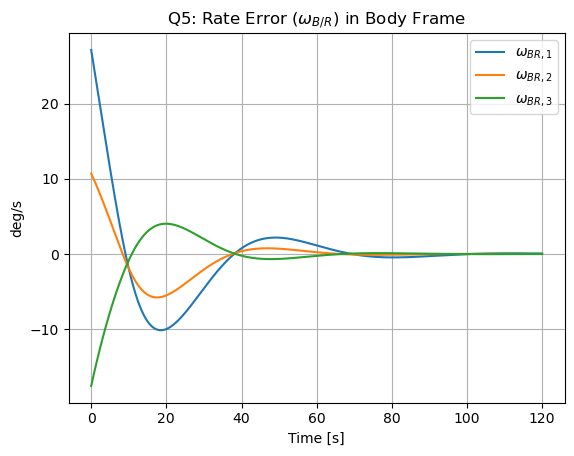

In [21]:
plt.figure()
plt.plot(t, omega_BR_deg[:, 0], label=r'$\omega_{BR,1}$')
plt.plot(t, omega_BR_deg[:, 1], label=r'$\omega_{BR,2}$')
plt.plot(t, omega_BR_deg[:, 2], label=r'$\omega_{BR,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Rate Error ($\\omega_{B/R}$) in Body Frame")
plt.legend()
plt.show()


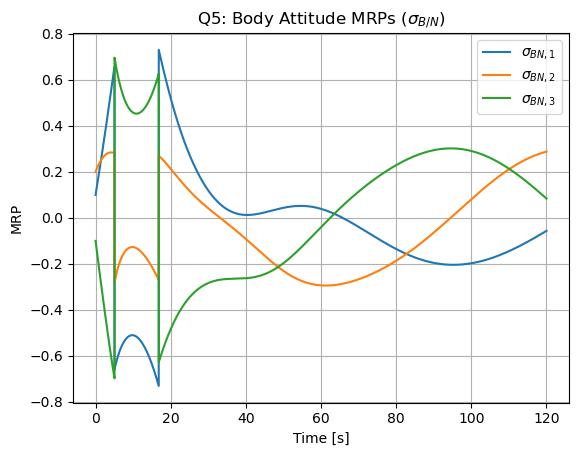

In [22]:
plt.figure()
plt.plot(t, sigma_BN[:, 0], label=r'$\sigma_{BN,1}$')
plt.plot(t, sigma_BN[:, 1], label=r'$\sigma_{BN,2}$')
plt.plot(t, sigma_BN[:, 2], label=r'$\sigma_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("Q5: Body Attitude MRPs ($\\sigma_{B/N}$)")
plt.legend()
plt.show()


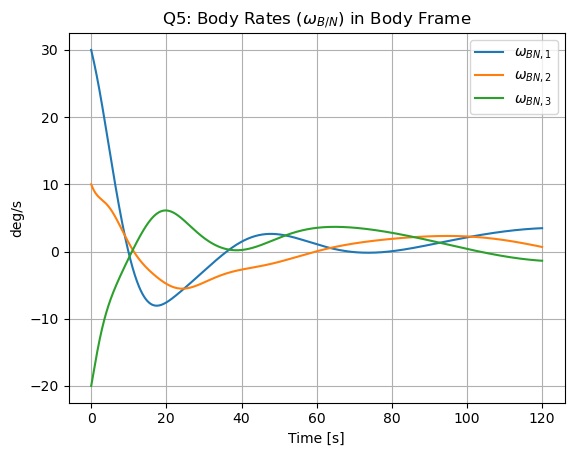

In [23]:
plt.figure()
plt.plot(t, omega_BN_deg[:, 0], label=r'$\omega_{BN,1}$')
plt.plot(t, omega_BN_deg[:, 1], label=r'$\omega_{BN,2}$')
plt.plot(t, omega_BN_deg[:, 2], label=r'$\omega_{BN,3}$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("deg/s")
plt.title("Q5: Body Rates ($\\omega_{B/N}$) in Body Frame")
plt.legend()
plt.show()


## CC2, Q5

In [24]:
def cc2_q5_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2/Q5 attitude tracking controller (PD on attitude and rate error).

    Control law:
        u_B = -K * sigma_BR - P * omega_BR_B

    Inputs:
        state["sigma_BN"], state["omega_BN_B"]
        ref["sigma_RN"], ref["omega_RN_R"]
        ctx["K"], ctx["P"]

    Output:
        u_B: (3,) control torque expressed in body frame B
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref["sigma_RN"], dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref["omega_RN_R"], dtype=float).reshape(3,)

    K = float(ctx["K"])
    P = float(ctx["P"])

    # Attitude error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Rate error
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = -K * sigma_BR - P * omega_BR_B
    return u_B



In [25]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.0, 0.0, 0.0], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "L_B": L
}

cc2q5_sim_results = simulate_CC(
    controller=cc2_q5_controller_u,
    plant_dynamics=cc_plant,
    state_derivative=cc_xdot,
    context=context,
    sigma0=sigma0,
    omega0_deg=omega0_deg,
    t0=0.0,
    tf=120.0,
    dt=0.01,
    ref_mode="tracking",
    f=0.05,
    report_time_s=20.0,
    report_quantity="sigma_BR",
)
cc2q5_sim_results


CC: ||sigma_B/R|| at t=20.000 s = 0.377862387698462


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102989,  0.20044504, -0.1013171 ,  0.52308769,  0.17482896,
         -0.3483798 ],
        [ 0.10206009,  0.20089004, -0.10263294,  0.52257656,  0.17512271,
         -0.34769394],
        ...,
        [-0.0673292 ,  0.3141675 ,  0.12502729,  0.06804106,  0.01167701,
         -0.0221562 ],
        [-0.06722017,  0.31422247,  0.12486535,  0.0680482 ,  0.0116588 ,
         -0.02216591],
        [-0.06711113,  0.31427737,  0.12470338,  0.06805532,  0.01164057,
         -0.02217561]]),
 'u': array([[-5.41482182, -1.4266146 ,  3.20435498],
        [-5.41525601, -1.43310985,  3.2011995 ],
        [-5.41568117, -1.43957694,  3.19804768],
        ...,
        [ 0.07050207, -0.1667854 , -0.09773463],
        [ 0.07040753, -0.16684373, -0.09762259],
        [ 0.07031297, -0.166902  , 

## CC2, Q6

In [26]:
def cc2_q6_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2/Q6 attitude tracking controller (PD + feedforward + gyro compensation).

    Control law:
        u_B = -K*sigma_BR - P*omega_BR_B
              + I*(omega_dot_RN_B - cross(omega_BN_B, omega_RN_B))
              + cross(omega_BN_B, I*omega_BN_B)

    Note:
        No "- L_B" term here (that appears in a later concept check).
        External torque L_B, if any, is modeled in the plant via ctx["L_B"].
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref["sigma_RN"], dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref["omega_RN_R"], dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref["omega_dot_RN_R"], dtype=float).reshape(3,)

    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    K = float(ctx["K"])
    P = float(ctx["P"])

    # Attitude error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Map reference rate/accel into B
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R

    # Rate error
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + np.cross(omega_BN_B, I @ omega_BN_B)
    )
    return u_B


In [32]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "deltaL_B": L
}

cc2q6_sim_results = simulate_CC(
    controller=cc2_q6_controller_u,
    plant_dynamics=cc_plant,
    state_derivative=cc_xdot,
    context=context,    
    sigma0=sigma0,
    omega0_deg=omega0_deg,
    t0=0.0,
    tf=120.0,
    dt=0.01,
    ref_mode="tracking",
    f=0.05,
    report_time_s=80.0,
    report_quantity="sigma_BR",
)
cc2q6_sim_results

CC: ||sigma_B/R|| at t=80.000 s = 0.134442565551099


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102984,  0.20044428, -0.10131741,  0.52322891,  0.17423502,
         -0.3484786 ],
        [ 0.10205986,  0.20088702, -0.10263419,  0.52285864,  0.17393824,
         -0.34789116],
        ...,
        [ 0.06768015,  0.24358509,  0.06565066,  0.05365285, -0.0110419 ,
         -0.03860909],
        [ 0.0677612 ,  0.24358807,  0.06549111,  0.05365173, -0.01106381,
         -0.03860704],
        [ 0.06784224,  0.24359098,  0.06533156,  0.05365059, -0.01108571,
         -0.03860497]]),
 'u': array([[-4.50077163, -5.5938201 ,  2.21276505],
        [-4.50371654, -5.57662934,  2.21988339],
        [-4.50673148, -5.55942183,  2.2269707 ],
        ...,
        [-0.50876535,  0.09414201, -0.16892653],
        [-0.50881475,  0.09417934, -0.16878899],
        [-0.5088349 ,  0.09420649, 

## CC2, Q7

In [28]:
def cc2_q7_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC2/Q7 attitude tracking controller (PD + feedforward + gyro compensation + disturbance cancelation).

    Control law:
        u_B = -K*sigma_BR - P*omega_BR_B
              + I*(omega_dot_RN_B - cross(omega_BN_B, omega_RN_B))
              + cross(omega_BN_B, I*omega_BN_B)
              - L_B

    Inputs:
        state["sigma_BN"], state["omega_BN_B"]
        ref["sigma_RN"], ref["omega_RN_R"], ref["omega_dot_RN_R"]
        ctx["I"], ctx["K"], ctx["P"], ctx["L_B"]

    Output:
        u_B: (3,) control torque expressed in body frame B
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref["sigma_RN"], dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref["omega_RN_R"], dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref["omega_dot_RN_R"], dtype=float).reshape(3,)

    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    K = float(ctx["K"])
    P = float(ctx["P"])
    L_B = np.asarray(ctx.get("L_B", np.zeros(3)), dtype=float).reshape(3,)

    # Attitude error
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Map reference rate/accel into body frame B
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R

    # Rate error
    omega_BR_B = omega_BN_B - omega_RN_B

    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - L_B
    )
    return u_B


In [30]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "modelL_B": L
}

cc2q7_sim_results = simulate_CC(
    controller=cc2_q7_controller_u,
    plant_dynamics=cc_plant,
    state_derivative=cc_xdot,
    context=context,
    sigma0=sigma0,
    omega0_deg=omega0_deg,
    t0=0.0,
    tf=120.0,
    dt=0.01,
    ref_mode="tracking",
    f=0.05,
    report_time_s=70.0,
    report_quantity="sigma_BR",
)
cc2q7_sim_results

CC: ||sigma_B/R|| at t=70.000 s = 0.032210380258408


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 0.1       ,  0.2       , -0.1       ,  0.52359878,  0.17453293,
         -0.34906585],
        [ 0.10102978,  0.20044435, -0.1013174 ,  0.52317894,  0.17427501,
         -0.34850358],
        [ 0.10205962,  0.20088729, -0.10263417,  0.52275878,  0.1740182 ,
         -0.34794107],
        ...,
        [-0.05652822,  0.28803467,  0.08422553,  0.06062813,  0.01184204,
         -0.02395373],
        [-0.05642969,  0.28807731,  0.0840797 ,  0.06063226,  0.01182167,
         -0.02396006],
        [-0.05633115,  0.28811987,  0.08393385,  0.06063638,  0.01180131,
         -0.02396637]]),
 'u': array([[-4.50077163, -5.5938201 ,  2.21276505],
        [-4.5031082 , -5.5766913 ,  2.21993471],
        [-4.50551686, -5.55954676,  2.22707241],
        ...,
        [ 0.04026097, -0.18178618, -0.06871974],
        [ 0.04017335, -0.18182018, -0.06860042],
        [ 0.04012846, -0.18184159, 

## CC3

In [34]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
L = np.array([0.5, -0.3, 0.2], dtype=float)

sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

context = {
    "I": I,
    "K": K,
    "P": P,
    "deltaL_B": L
}

cc3_sim_results = simulate_CC(
    controller=cc2_q6_controller_u,
    plant_dynamics=cc_plant,
    state_derivative=cc_xdot,
    context=context,
    sigma0=sigma0,
    omega0_deg=omega0_deg,
    t0=0.0,
    tf=120.0,
    dt=0.01,
    ref_mode="regulator",
    f=0.0,
    report_time_s=35.0,
    report_quantity="sigma_BR",
)
cc3_sim_results

CC: ||sigma_B/R|| at t=35.000 s = 0.276957350317443


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01029590e-01,  2.00444196e-01, -1.01317424e-01,
          5.23075181e-01,  1.74127004e-01, -3.48541934e-01],
        [ 1.02058872e-01,  2.00886667e-01, -1.02634253e-01,
          5.22551596e-01,  1.73721328e-01, -3.48017849e-01],
        ...,
        [ 9.70826875e-02, -5.99775604e-02,  4.21439839e-02,
          6.45167214e-04,  8.43179128e-04, -3.16803472e-04],
        [ 9.70841945e-02, -5.99751947e-02,  4.21438048e-02,
          6.45979920e-04,  8.42039900e-04, -3.17746812e-04],
        [ 9.70857042e-02, -5.99728311e-02,  4.21436231e-02,
          6.46791060e-04,  8.40900615e-04, -3.18688861e-04]]),
 'u': array([[-6.04060518, -6.40073829,  1.70602786],
        [-6.03935257, -6.38976372,  1.71496861],
        [-6.03810093, -6.37879226,  1.72389083],
  

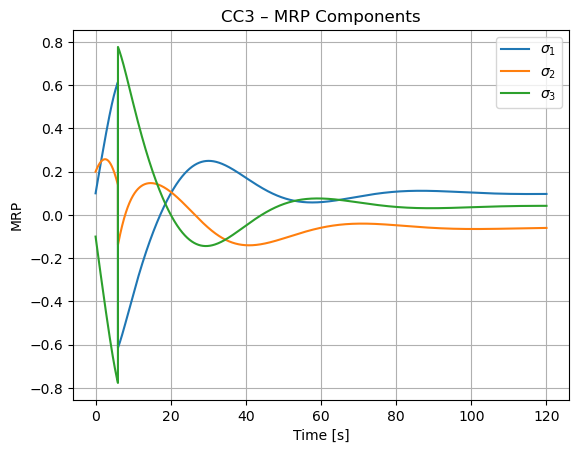

In [35]:
t = cc3_sim_results['t']
x = cc3_sim_results['x']
u = cc3_sim_results['u']
V = cc3_sim_results['V']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("CC3 – MRP Components")
plt.legend()
plt.show()

In [36]:
cc3_sim_results["sigma_BR"][-1]

array([ 0.0970857 , -0.05997283,  0.04214362])

## CC4

In [42]:
def cc4_controller_u(
    t: float,
    state: dict,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    CC4 nonlinear integral tracking control torque u_B (expressed in B).

    Inputs:
        state["sigma_BN"], state["omega_BN_B"], state["eta"]
        ref["sigma_RN"], ref["omega_RN_R"], ref["omega_dot_RN_R"]
        ctx["I"], ctx["K"], ctx["P"], ctx["Ki"], ctx["omega_BR0_B"], ctx["modelL_B"] (optional)

    Output:
        u_B: (3,) control torque in body frame B
    """
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)
    eta = np.asarray(state["eta"], dtype=float).reshape(3,)

    sigma_RN = np.asarray(ref["sigma_RN"], dtype=float).reshape(3,)
    omega_RN_R = np.asarray(ref["omega_RN_R"], dtype=float).reshape(3,)
    omega_dot_RN_R = np.asarray(ref["omega_dot_RN_R"], dtype=float).reshape(3,)

    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    K = float(ctx["K"])
    P = float(ctx["P"])
    Ki = float(ctx["Ki"])
    omega_BR0_B = np.asarray(ctx["omega_BR0_B"], dtype=float).reshape(3,)
    modelL_B = np.asarray(ctx.get("modelL_B", np.zeros(3)), dtype=float).reshape(3,)

    # Attitude error (MRPs): sigma_BR = sigma_BN (-) sigma_RN
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")

    # Map reference rates/accel into body frame B
    C_BN = ak.MRP_to_DCM(sigma_BN)
    C_RN = ak.MRP_to_DCM(sigma_RN)
    C_BR = C_BN @ C_RN.T

    omega_RN_B = C_BR @ omega_RN_R
    omega_dot_RN_B = C_BR @ omega_dot_RN_R

    # Rate error in B
    omega_BR_B = omega_BN_B - omega_RN_B

    # Integral composite variable z
    z = K * eta + (I @ (omega_BR_B - omega_BR0_B))

    # Nonlinear integral tracking law
    u_B = (
        -K * sigma_BR
        -P * omega_BR_B
        + I @ (omega_dot_RN_B - np.cross(omega_BN_B, omega_RN_B))
        + np.cross(omega_BN_B, I @ omega_BN_B)
        - P * Ki * z
        - modelL_B
    )
    return u_B


In [43]:
def cc4_plant(
    t: float,
    state: dict,
    u_B: np.ndarray,
    ref: dict,
    ctx: dict,
) -> dict:
    """
    CC4 plant dynamics with integral state.

    State:
        state["sigma_BN"]   : MRPs of B wrt N
        state["omega_BN_B"]: angular rate of B wrt N, expressed in B
        state["eta"]        : integral state (eta_dot = sigma_BR)

    Plant dynamics:
        I * omega_dot = u_B + deltaL_B - omega x (I * omega)
        sigma_dot     = 0.25 * B(sigma) * omega
        eta_dot       = sigma_BR

    Notes:
        - deltaL_B is the actual external torque applied to the spacecraft
        - modelL_B is NOT used here (controller-only concept)
    """
    # --- Unpack state ---
    sigma_BN = np.asarray(state["sigma_BN"], dtype=float).reshape(3,)
    omega_BN_B = np.asarray(state["omega_BN_B"], dtype=float).reshape(3,)
    eta = np.asarray(state["eta"], dtype=float).reshape(3,)

    # --- Unpack reference ---
    sigma_RN = np.asarray(ref["sigma_RN"], dtype=float).reshape(3,)

    # --- Parameters ---
    I = np.asarray(ctx["I"], dtype=float).reshape(3, 3)
    deltaL_B = np.asarray(ctx["deltaL_B"], dtype=float).reshape(3,)

    # --- Attitude kinematics ---
    sigma_dot = 0.25 * ak.Bmat_MRP(sigma_BN) @ omega_BN_B

    # --- Rigid-body dynamics ---
    omega_dot_B = np.linalg.solve(
        I,
        u_B + deltaL_B - np.cross(omega_BN_B, I @ omega_BN_B)
    )

    # --- Integral state dynamics ---
    sigma_BR = mrp_compose(sigma_BN, sigma_RN, mode="sub")
    eta_dot = sigma_BR

    return {
        "sigma_BN": sigma_dot,
        "omega_BN_B": omega_dot_B,
        "eta": eta_dot,
    }


In [44]:
def cc4_xdot(
    t: float,
    x: np.ndarray,
    controller,
    plant_dynamics,
    ref: dict,
    ctx: dict,
) -> np.ndarray:
    """
    State derivative adapter for CC4 under the new simulate_CC interface.

    Inputs:
        x: [sigma_BN (3), omega_BN_B (3), eta (3)]
        controller: u_B = controller(t, state, ref, ctx)
        plant_dynamics: state_dot = plant_dynamics(t, state, u_B, ref, ctx)

    Output:
        xdot: [sigma_dot (3), omega_dot_B (3), eta_dot (3)]
    """
    x = np.asarray(x, dtype=float).reshape(-1,)
    if x.size != 9:
        raise ValueError(f"cc4_xdot expects state length 9, got {x.size}")

    state = {
        "sigma_BN": x[0:3],
        "omega_BN_B": x[3:6],
        "eta": x[6:9],
    }

    u_B = controller(t, state, ref, ctx)
    state_dot = plant_dynamics(t, state, u_B, ref, ctx)

    xdot = np.hstack((state_dot["sigma_BN"], state_dot["omega_BN_B"], state_dot["eta"]))
    return xdot


In [46]:
I = np.diag([100.0, 75.0, 80.0])
K = 5.0
P = 10.0
Ki = 1.0

f = 0.05

deltaL_B = np.array([0.5, -0.3, 0.2], dtype=float)


sigma0 = np.array([0.1, 0.2, -0.1])
omega0_deg = np.array([30.0, 10.0, -20.0])

sigma_RN_0 = np.array([0.0, 0.3, 0.0], dtype=float)
sigma_RN_dot_0 = np.array([0.2 * f, 0.0, -0.3 * f], dtype=float)
omega_RN_R_0 = 4.0 * (ak.BInvmat_MRP(sigma_RN_0) @ sigma_RN_dot_0)

C_BN_0 = ak.MRP_to_DCM(sigma0)
C_RN_0 = ak.MRP_to_DCM(sigma_RN_0)
C_BR_0 = C_BN_0 @ C_RN_0.T
omega_RN_B_0 = C_BR_0 @ omega_RN_R_0

omega_BR0_B = np.deg2rad(omega0_deg) - omega_RN_B_0

context = {
    "I": I,
    "K": K,
    "P": P,
    "Ki": Ki,
    "deltaL_B": deltaL_B,              # plant disturbance (unknown torque)
    "modelL_B": np.zeros(3),          # controller assumes L = 0 (prompt)
    "omega_BR0_B": omega_BR0_B,       # needed for z definition
}

eta0 = np.zeros(3) 

cc4_sim_results = simulate_CC(
    controller=cc4_controller_u,
    plant_dynamics=cc4_plant,
    state_derivative=cc4_xdot,
    context=context,
    sigma0=sigma0,
    omega0_deg=omega0_deg,
    eta0=eta0,
    t0=0.0,
    tf=240.0,
    dt=0.01,
    ref_mode="tracking",
    f=f,
    report_time_s=45.0,
    report_quantity="sigma_BR",
)
cc3_sim_results

CC: ||sigma_B/R|| at t=45.000 s = 0.098811545045723


{'t': array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.1998e+02, 1.1999e+02,
        1.2000e+02]),
 'x': array([[ 1.00000000e-01,  2.00000000e-01, -1.00000000e-01,
          5.23598776e-01,  1.74532925e-01, -3.49065850e-01],
        [ 1.01029590e-01,  2.00444196e-01, -1.01317424e-01,
          5.23075181e-01,  1.74127004e-01, -3.48541934e-01],
        [ 1.02058872e-01,  2.00886667e-01, -1.02634253e-01,
          5.22551596e-01,  1.73721328e-01, -3.48017849e-01],
        ...,
        [ 9.70826875e-02, -5.99775604e-02,  4.21439839e-02,
          6.45167214e-04,  8.43179128e-04, -3.16803472e-04],
        [ 9.70841945e-02, -5.99751947e-02,  4.21438048e-02,
          6.45979920e-04,  8.42039900e-04, -3.17746812e-04],
        [ 9.70857042e-02, -5.99728311e-02,  4.21436231e-02,
          6.46791060e-04,  8.40900615e-04, -3.18688861e-04]]),
 'u': array([[-6.04060518, -6.40073829,  1.70602786],
        [-6.03935257, -6.38976372,  1.71496861],
        [-6.03810093, -6.37879226,  1.72389083],
  

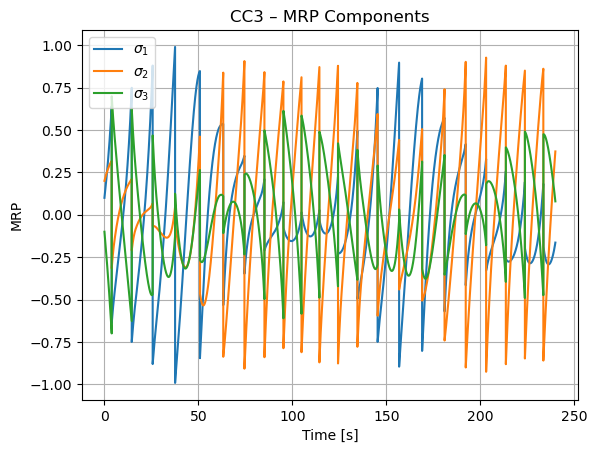

In [47]:
t = cc4_sim_results['t']
x = cc4_sim_results['x']
u = cc4_sim_results['u']
V = cc4_sim_results['V']

sigma = x[:, 0:3]
omega = x[:, 3:6]
omega_deg = np.rad2deg(omega)

plt.figure()
plt.plot(t, sigma[:, 0], label=r'$\sigma_1$')
plt.plot(t, sigma[:, 1], label=r'$\sigma_2$')
plt.plot(t, sigma[:, 2], label=r'$\sigma_3$')
plt.grid(True)
plt.xlabel("Time [s]")
plt.ylabel("MRP")
plt.title("CC3 – MRP Components")
plt.legend()
plt.show()